# Arithmétique de grands entiers


Dans ce TP, on représente des _grands entiers_, c-a-d. des entiers qui ne sont pas des `int` de Python. On code différents algorithmes d'addition de tels entiers. Puis on effectue une analyse expérimentale des performances de ces algorithmes.

**Remarque.** Si une valeur entière n'est pas exactement représentable par un `int` python, le langage "bascule" automatiquement vers les entiers de précision arbitraire fournis par la bibliothèque [GMP](http://gmplib.org). Cette remarque sera utile pour écrire facilement des tests unitaires de nos traitements.

Exemple.

In [1]:
for i in range(60,70):
    x = 2 ** i
    print(i, x, type(x))

60 1152921504606846976 <class 'int'>
61 2305843009213693952 <class 'int'>
62 4611686018427387904 <class 'int'>
63 9223372036854775808 <class 'int'>
64 18446744073709551616 <class 'int'>
65 36893488147419103232 <class 'int'>
66 73786976294838206464 <class 'int'>
67 147573952589676412928 <class 'int'>
68 295147905179352825856 <class 'int'>
69 590295810358705651712 <class 'int'>


Dans ce TP, nous allons mettre en oeuvre une solution alternative (qui, disons-le tout de suite, sera beaucoup moins performante que les versions optimisées de GMP).

## imports

On rassemble dans la cellule suivante **tous** les `import` dont on besoin au fur et à mesure de nos réponses. Ce qui permet de la relacer facilement pour d'éventuels redémarrage de noyau et exécution partielle du notebook. 

In [2]:
from random import randint
import time
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit
from math import floor, log, sqrt
from gmpy2 import mpz, mul

## Représentation de grands entiers positifs

On représente un entier **positif** par la liste de ces chiffres (en base 10) stockés dans une liste par ordre croissant de son exposant en notation de position : le chiffre de plus faible exposant est le plus à droite de cette représentation .

Ainsi $123 = 1 + 2 \times 10 + 3 \times 10^2$  sera représenté par la liste `[1, 2, 3]`. 

### `inttointlist0()`

In [3]:
def inttointlist0(n : int) -> list[int]:
    if n == 0:
        return [0]
    res = []
    while n > 0:
        res = [n % 10] + res
        n = n // 10
    return res

In [4]:
assert inttointlist0(0) == [0]
assert inttointlist0(4) == [4]
assert inttointlist0(84) == [8, 4]
assert inttointlist0(123) == [1, 2, 3]

### `intlisttoint0`

In [5]:
def intlisttoint0(l : list[int]) -> int:
    res = 0
    for i in range(-1, -len(l)-1, -1):
        res = res + l[i]*10**(-i-1)
    return res

In [6]:
assert intlisttoint0([0]) == 0
assert intlisttoint0([8, 9]) == 89
assert intlisttoint0([1, 2, 3]) == 123

### `strtointlist()`

In [7]:
def strtointlist(s : str) -> list[int]:
    return [int(d) for d in s]

In [8]:
assert strtointlist("0") == [0]
assert strtointlist("123") == [1, 2, 3]

### `intlisttostr()`

In [9]:
def intlisttostr(l : list[int]) -> str:
    res = ""
    for i in range(len(l)):
        res = res + str(l[i])
    return res

In [10]:
assert intlisttostr([0]) == "0"
assert intlisttostr([1, 2, 3]) == "123"

## `add0()`: l'addition simple de grands entiers positifs

Une première solution `add0()` effectue 2 parcours :
1. un premier parcours effectue l'addition chiffre à chiffre des opérandes
2. un second propage les retenues issues de l'étape précédente

In [11]:
def add0(u: list[int], v: list[int]) -> list[int]:
    '''cette solution fait 2 parcours de res. 
    1 seul est possible en propageant la retenue au fur et à mesure'''
    if len(u) < len(v):
        u, v = v, u
    assert len(u) >= len(v)
    
    # add chiffre à chiffre après copie de u
    res = u.copy()
    for i in range(-1, -len(v)-1, -1):
        res[i] = res[i] + v[i]
    #print("res", res)

    # propag retenues de gauche à droite       
    for i in range(-1, -len(res)-1, -1): 
        if res[i] > 9: # il y une retenue
            res[i] = res[i] % 10
            if -len(res)-1 < i-1: 
                res[i-1] += 1
            else:
                res.insert(0, 1) # ajout 1 comme chiffre de poids fort 
                #res = [1] + res
    return res      

In [12]:
assert add0([2], [1]) == [3]
assert add0([1], [2]) == [3]
assert add0([1], [2, 0]) == [2, 1]
assert add0([8], [3]) == [1, 1]
assert add0([8, 9], [1]) == [9, 0]
assert add0([9, 9], [2]) == [1, 0, 1]
assert add0([], [3]) == [3]
assert add0([0], [3]) == [3]

## Quid des négatifs ?

Avant d'aller plus loin, comment représenter des grands entiers négatifs de façon cohérente avec l'addition définie par `add`?

On va donc convenir de stocker un grand entier négatif en notation "signe-entier".
Ainsi le signe négatif est un `-1` supplémentaire situé en début de la représentation, c-a-d. comme chiffre de plus haut poids dans la représentation adoptée.

Ainsi `-12345` sera représenté par la liste de 6 entiers `[-1, 1, 2, 3, 4, 5]`. 

**Remarque.** Il faut préciser comment traiter la valeur nulle :
- le "grand" entier 0 **ne peut être représenté que par `[0]`**
- il n'existe **pas** de zéro négatif, _ie._ pas de `[-1, 0]`

On va étendre l'addition `add0()` pour traiter de tels opérandes négatifs.

Pour cela, on doit définir les fonctions suivantes :
- `signe()` qui retourne le signe d'un grand entier 
- `neg()` qui retourne l'opposé d'un grand entier
- `ge()` (pour _greater or equal_) qui compare 2 grands entiers positifs
Et aussi compléter :
- `inttointlist()`
- `intlisttoint()`


#### `signe()`

In [13]:
def signe(u: list[int]) -> int:
    '''
    retourne 0 si u est positif ou vide, sinon retourne -1
    cette version suppose le signe placé comme premier chiffre de u
    le cas u == [] est traité mais devrait pouvoir être évité dans les traitements qui calculent u 
    '''
    if u == []:
        return 0
    elif u[0] >= 0:
        return 0
    return -1

In [14]:
assert signe([1, 2, 3]) == 0
assert signe([-1, 1, 2, 3]) == -1
assert signe([]) == 0
assert signe([0]) == 0
assert signe([-1, 0]) == -1

#### `neg()`

In [15]:
def neg(u: list[int]) -> list[int]:
    '''
    retourne le négatif de u non nul
    '''
    if u == [] or u == [0]:
        return [0]
    if signe(u) == 0 :
        return [-1] + u
    else:
        return u[1:]

In [16]:
assert neg([1, 2, 3]) == [-1, 1, 2, 3]
assert neg([-1, 1, 2, 3]) == [1, 2, 3]
assert neg([0]) == [0]
assert neg([]) == [0]
#assert neg([-1, 0]) == [0]

#### `ge()`

On convient que les différentes représentations de 0 sont égales.

In [20]:
def ge(u: list[int], v: list[int]) -> bool:
    ''' 
    comparaison _greater or equal_ u >= v
    '''
    
    def gepositifs(u: list[int], v: list[int]) -> bool:
        '''
        comparaison u >= v où u et v sont positifs ou nuls
        '''
        # u et v sont positifs sans 0 inutiles
        assert signe(u) == 0 and signe(v) == 0 
        
        # des cas simples
        if len(u) > len(v):
            return True
        elif len(u) < len(v):
            return False
        # moins simple : u et v de même taille
        # comparaison chiffre à chiffre à partir du plus haut chiffre
        i = 0 
        while i < len(u):
            if u[i] > v[i]:
                return True
            elif u[i] < v[i]:
                return False
            i += 1
        return True # égalité
        
    # u=0 
    if u == [] or u == [0]:
        if v == [0] or v == [] or signe(v) == -1:
            return True
        return False
    # v == 0
    if v == [] or v == [0]:
        if signe(u) == 0:
            return True
        return False

    # u >= 0 et v < 0
    if signe(u) == 0 and signe(v) == -1:
        return True

    # u < 0 et v >= 0
    if signe(u) == -1 and signe(v) == 0:
        return False
 
    # u >= 0 et v >= 0
    if signe(u) == 0 and signe(v) == 0:
        return gepositifs(u, v)

    # u < 0 et v < 0
    if signe(u) == -1 and signe(v) == -1:
        return gepositifs(neg(v), neg(u))   

In [21]:
# u ou v == 0
assert ge([0], [0]) == True
assert ge([], [0]) == True
assert ge([0], []) == True
assert ge([0], [1]) == False
assert ge([1], [0]) == True

# u > 0 et v > 0
assert ge([1,1], [3]) == True
assert ge([1,1], [1, 0]) == True
assert ge([1,1], [1, 1]) == True
assert ge([1,1], [3, 4]) == False
assert ge([1,1], [3, 4, 1]) == False
assert ge([2], [1]) == True
assert ge([2], [2]) == True
assert ge([2], [3]) == False

# u > 0 et v < 0
assert ge([1,1], [-1, 3]) == True
assert ge([1,1], [-1, 3, 4]) == True
assert ge([1,1,1], [-1, 1]) == True 

# u < 0 et v > 0
assert ge([-1,1], [3]) == False
assert ge([-1,1], [1, 3, 4]) == False
assert ge([-1,1,1], [1, 1]) == False 

# u > 0 et v > 0
assert ge([-1,1], [-1,3]) == True
assert ge([-1,1,1], [-1, 1, 0]) == False
assert ge([-1,1], [-1, 1]) == True
assert ge([-1,1], [-1, 3, 4]) == True
assert ge([-1,1,1], [-1, 3]) == False
assert ge([-1, 2], [-1, 1]) == False
assert ge([-1, 2], [-1, 2]) == True
assert ge([-1, 2], [-1, 3]) == True

### `inttointlist()`

In [19]:
def inttointlist(n : int) -> list[int]:
    if n >= 0:
        return inttointlist0(n)
    else:
        return [-1] + inttointlist0(-n)

In [20]:
assert inttointlist(0) == [0]
assert inttointlist(-4) == [-1, 4]
assert inttointlist(84) == [8, 4]
assert inttointlist(-123) == [-1,1, 2, 3]

### `intlisttoint()`

In [21]:
def intlisttoint(l : list[int]) -> int:
    if l == []:
        return 0
    elif signe(l) == 0:
        return intlisttoint0(l)
    else:
        return - intlisttoint0(neg(l))

In [22]:
assert intlisttoint([]) == 0
assert intlisttoint([0]) == 0
assert intlisttoint([8, 9]) == 89
assert intlisttoint([1, 2, 3]) == 123
assert intlisttoint([-1, 8, 9]) == -89
assert intlisttoint([-1, 1, 2, 3]) == -123

### `add()` : addition de 2 grands entiers de signe quelconque

On peut maintenant y aller !

In [23]:
for i in range(-1, -3, -1):
    print(i)

-1
-2


In [24]:
def add(u: list[int], v: list[int]) -> list[int]:
    '''add de grands entiers de signe quelconque
    la propagation de la retenue est effectuée en 0 parcours supplémentaire
    '''
    def sub(u: list[int], v: list[int]) -> list[int]:
        '''u - v avec u > 0 et v > 0 et |u|>|v|
        '''
        assert signe(u) == 0 
        assert signe(v) == 0
        assert ge(u, v) == True # u >= v >= 0
        
        # u ou v == 0
        if u == [0] or u == []:
            return v
        if v == [0] or v == []:
            return u

        res = u
        # soustraction de chaque chiffre de v 
        # avec propagation retenue
        for i in range(-1, -len(v)-1, -1):
            if u[i] >= v[i]:
                res[i] -= v[i]
            else:
                res[i] += 10 - v[i]
                res[i-1] -= 1                  
        
        # normalisation des 0 à gauche
        while len(res) > 1 and res[0] == 0:
            res.pop(0)
        '''
        for i in range(-1, -len(u), -1):
            if res[i] < 0:
                res[i] = res[i] % 10
                res[i - 1] = res[i] - 1
            if res[-len(u)] < 0:
                res[-len(u)] = res[i] % 10
                res = [1]
        '''        
        return res
    
    # u >= 0 et v >= 0
    if signe(u) == 0 and signe(v) == 0:
        if ge(u, v):
            return add0(u, v)
        else:
            return add0(v, u)
    
    # u < 0 et v < 0
    if signe(u) == -1 and signe(v) == -1:
        return neg(add0(neg(u), neg(v)))
    
    # u >= 0 et v < 0:
    if signe(u) == 0 and signe(v) == -1:
        if ge(u, neg(v)):
            return sub(u, neg(v))
        else:
            return neg(sub(neg(v), u))
        
    # u < 0 et v >= 0
    else:
        u, v = v, u
        # u - v avec u > 0 et v > 0 
        return add(u, v)
    

In [25]:
assert add([2], [1]) == [3]
assert add([1], [2]) == [3]
assert add([1], [2, 0]) == [2, 1]
assert add([8], [3]) == [1, 1]
assert add([8, 9], [1]) == [9, 0]
assert add([9, 9], [2]) == [1, 0, 1]

assert add([2], [-1, 1]) == [1]
assert add([1], [-1, 2]) == [-1, 1]
assert add([-1, 1], [2, 0]) == [1, 9]
assert add([8], [-1, 3]) == [5]
assert add([-1, 8, 9], [-1, 1]) == [-1, 9, 0]
assert add([-1, 9, 9], [-1, 2]) == [-1, 1, 0, 1]
assert add([1,2], [-1,5]) == [7]
assert add([5, 4], [-1, 4, 8]) == [6]

assert add([8], [-1, 8]) == [0]
assert add([-1, 8], [8]) == [0]
assert add([-1, 8], []) == [-1, 8]

## Multiplication de grands entiers : méthode naïve 

La multiplication naïve (celle "de la petite école" ou par multiplications-décalages) consiste à des multiplications d'un opérande par un nombre à un seul chiffre extrait de l'autre opérande, à des décalages des résultats ainsi obtenus et à une addition finale. 

La multiplication d'un grand entier par un nombre à une chiffre peut introduire des retenues à propager dans la représentation choisie : ici une liste de chiffres.
On commence par la propagation de retenues présentes dans une liste d'entiers arbitraires de façon à obtenir la représentation d'un grand entier.

### `propagerretenue()`

In [26]:
def propagerretenue(u: list[int]) -> list[int]:
    '''propage la retenue dans un grand entier'''
    for i in range(-1, -len(u)-1, -1):
        (r, u[i]) = divmod(u[i], 10)
        if r > 0:
            if -len(u)-1 < i-1: 
                u[i-1] += r
            else:
                u.insert(0, r) # ajout chiffre de poids fort
    return u

In [27]:
assert propagerretenue([1, 2, 3]) == [1, 2, 3]
assert propagerretenue([11, 2, 33]) == [1, 1, 5, 3]
assert propagerretenue([11, 9, 33]) == [1, 2, 2, 3]

### `multchiffre()`

On continue par la multiplication d'un grand entier par un nombre à un chiffre, propagation des retenues incluse.

In [28]:
def multchiffre(u: list[int], c: int) -> list[int]:
    '''effectue la multiplication chiffre à chiffre du grand entier u 
    par le chiffre c'''
    if c == 0:
        return [0]
    res = [0 for v in u]
    for i in range(len(u)):
        res[i] = c * u[i]
    return propagerretenue(res)

In [29]:
assert multchiffre([3, 2, 1], 0) == [0]
assert multchiffre([3, 2, 1], 1) == [3, 2, 1]
assert multchiffre([3, 2, 1], 4) == [1, 2, 8, 4]
assert multchiffre([3, 2, 1], 9) == [2, 8, 8, 9]

### Décalage

On complète avec le décalage d'un grand entier (pour les résultats des multiplications partielles avant sommation).

### `decaler()`

In [30]:
def decaler(u: list[int], p: int) -> list[int]:
    '''décale le grand entier u de p positions vers la gauche
    cad. vers la droite de la représentation choisie (notation de position) 
    et complète avec des 0, ie. u -> u * 10**p'''
    return u + [0 for i in range(p)]

In [31]:
assert decaler([1], 2) == [1, 0, 0]
assert decaler([1], 3) == [1, 0, 0, 0]
assert decaler([9, 9], 0) == [9, 9]
assert decaler([9, 9], 1) == [9, 9, 0]

### `mult()`

On peut maintenant coder la multiplication naïve de deux grands entiers.

In [32]:
def mult(u: list[int], v: list[int]) -> list[int]:
    '''effectue la multiplication "petite école" de 2 grands entiers '''
    if len(u) < len(v):
        u, v = v, u
    res = [0]
    for i in range(-1, -len(v)-1, -1):
        r = multchiffre(u, v[i])
        res = add(res, decaler(r, -i-1))
    return res

In [33]:
assert mult([3, 2, 1], [0]) == [0]
assert mult([3, 2, 1], [1]) == [3, 2, 1]
assert mult([3, 2, 1], [1, 0]) == [3, 2, 1, 0]

## Vérification 

Pour des entiers aléatoires, on compare le résultat de `mult()` et des fonctions de conversions de format avec les résultats de l'opérateur natif de python.

In [34]:
from random import randint
help(randint)

Help on method randint in module random:

randint(a, b) method of random.Random instance
    Return random integer in range [a, b], including both end points.



In [35]:
nbtests = 20
a = 0
b = 2**70
for i in range(nbtests):
    x = randint(a, b)
    y = randint(a, b)
    mon_x = inttointlist(x)
    mon_y = inttointlist(y)
    mon_xy = mult(mon_x, mon_y)
    assert inttointlist(x*y) ==  mon_xy
    assert x*y == intlisttoint(mon_xy)

## Complexité

Quelle est la complexité de cette multiplication ? Donner une expression précise puis son comportement asymptotique.

- n chiffres ->  n multiplications `multchiffres`, n-1 décalages et n-1 additions d'au plus n+1 chiffres
- 1 `multchiffres` -> n multiplications scalaires, au plus n retenues propagées => =< n + ...
-`propagerretenue` -> n divisions entières et au plus n additions => ... <= 2n, soit <= 3n 
total <= n x 3n + (n-1) + (n-1)x(n+1) = 4n^2 + n - 2 = O(n^2) 

In [36]:
def comp_theorique(vect_n: list[int]) -> list[int]:
    '''retourne le vecteur des complexités théoriques 
    pour différents n (entrés sous la forme d'un vecteur)'''
    return [4*n*n + n - 2 for n in vect_n]

## Timings

### Mesures

On mesure l'efficacité de ces solutions en fonction le la taille des entiers concernés.
On inclut la conversion d'un entier `int` en un grand entier `intlist`.  

#### Une première mesure 

**Mesure 1 :** _chaque itération_ contient la génération des opérandes (x, y) et le test.   

In [37]:
nbtests = 20
dizaines = [n for n in range(2, 100, 2)]
timings = []

for nbchiffres in dizaines: 
    a = 10 ** nbchiffres
    b = (10 ** (nbchiffres + 1)) - 1
    tempstot = 0.
    
    for i in range(nbtests):
        x = randint(a, b)
        y = randint(a, b)
        
        t0 = time.perf_counter()
        mon_x = inttointlist(x)
        mon_y = inttointlist(y)
        mon_xy = mult(mon_x, mon_y)
        t = time.perf_counter()
        
        tempstot += (t - t0)
    timings.append(tempstot/nbtests)
 
#for i in range(len(dizaines)):
#    print("n=", dizaines[i], "t=", "{:5.3e}".format(timings[i]))



#### Une seconde mesure

**Mesure 2 :** en créant une fois pour toutes les échantillons de (x, y) ; ce qui permet de mesurer une boucle de multiplications.

In [38]:
import numpy as np

nbtests = 20
dizaines = [n for n in range(2, 100, 2)]
timings2 = []

for nbchiffres in dizaines: 
    a = 10 ** nbchiffres
    b = (10 ** (nbchiffres + 1)) - 1
    tempstot = 0.
    
    # génération des vecteurs d'opérandes
    x = np.zeros(nbtests)
    y = np.zeros(nbtests)
    for i in range(nbtests):
        x[i] = randint(a, b)
        y[i] = randint(a, b)
        
    # mesure de nbtests multiplications 
    t0 = time.perf_counter()
    for i in range(nbtests):
        mon_x = inttointlist(x[i])
        mon_y = inttointlist(y[i])
        mon_xy = mult(mon_x, mon_y)
    t = time.perf_counter()   
    tempstot = (t - t0)
        
    timings2.append(tempstot/nbtests)

# for i in range(len(dizaines)):
#    print("n=", dizaines[i], "t=", "{:5.3e}".format(timings2[i]))


#### Une troisième mesure

On reprend _Mesure 1_ en excluant la conversion de la mesure

In [39]:
#import time

nbtests = 20
dizaines = [n for n in range(2, 100, 2)]
timings3 = []

for nbchiffres in dizaines: 
    a = 10 ** nbchiffres
    b = (10 ** (nbchiffres + 1)) - 1
    tempstot = 0.
    
    for i in range(nbtests):
        x = randint(a, b)
        y = randint(a, b)
        
        mon_x = inttointlist(x)
        mon_y = inttointlist(y)
        
        t0 = time.perf_counter()
        mon_xy = mult(mon_x, mon_y)
        t = time.perf_counter()
        
        tempstot += (t - t0)
    timings3.append(tempstot/nbtests)
 
#for i in range(len(dizaines)):
#    print("n=", dizaines[i], "t=", "{:5.3e}".format(timings[i]))



### Tracés

Text(0.5, 1.0, 'timings : multiplication naïve')

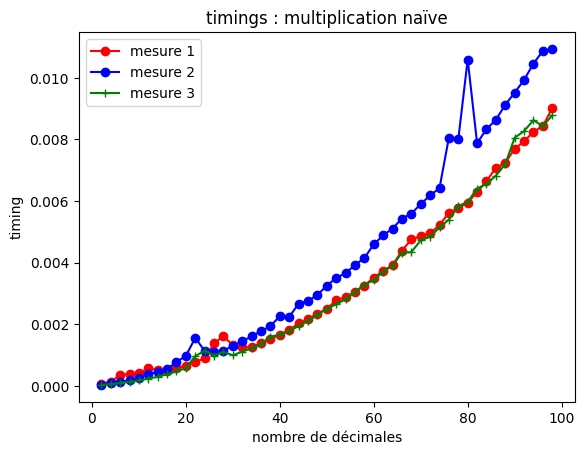

In [40]:
#import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(dizaines, timings, "ro-", label="mesure 1")
ax.plot(dizaines, timings2, "bo-", label="mesure 2")
ax.plot(dizaines, timings3, "g+-", label="mesure 3")
#ax.plot(dizaines, comp_theorique(dizaines), "k+-", label="theorie")

ax.legend(loc='upper left')
ax.set_xlabel("nombre de décimales")
ax.set_ylabel("timing")
ax.set_title("timings : multiplication naïve")

Text(0.5, 1.0, 'timings : multiplication naïve')

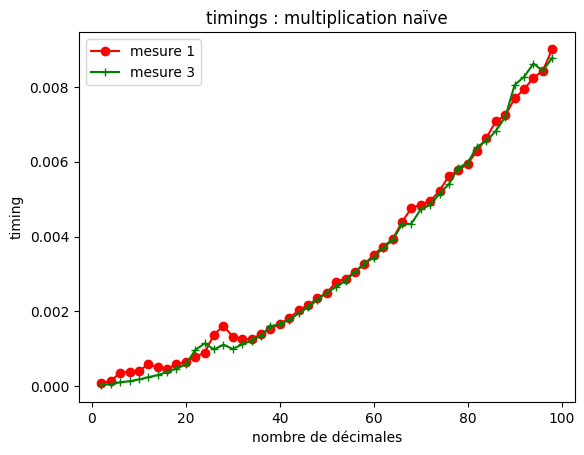

In [41]:
#import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(dizaines, timings, "ro-", label="mesure 1")
#ax.plot(dizaines, timings2, "bo-", label="mesure 2")
ax.plot(dizaines, timings3, "g+-", label="mesure 3")
#ax.plot(dizaines, comp_theorique(dizaines), "k+-", label="theorie")

ax.legend(loc='upper left')
ax.set_xlabel("nombre de décimales")
ax.set_ylabel("timing")
ax.set_title("timings : multiplication naïve")

### Conclusion

- De façon aléatoire, toutes ces Mesures peuvent présenter des irrégularités 
- Mesure 1 (génération opérandes et multiplication) est systématiquement moins élevée que  Mesure 2 (génération et multiplication séparées) ; ce n'était pas évident au départ.
    - Mesure 1 bénéficie de la localité des opérandes tandis que la mesure 2 nécessite l'accès aux opérandes dans les listes créées plus tôt 
- Mesure 1 vs. Mesure 3 ?
    - elle sont indiscernables 
- **on va donc favoriser Mesure 1**
- on observe une tendance non-linéaire (quadratique certainement) en fonction du nombre de chiffres à partir d'un nombre de décimales supérieure à 20
    - on vérifie avec une échelle log sur les ordonnées
- le traitement des "petits" grands entiers (jusqu'à 20 décimales) est un peu plus chaotique. 
    - il faudrait peut être augmenter le nombre d'échantillon et jeter les première mesures.

Text(0.5, 1.0, 'timings : multiplication naïve')

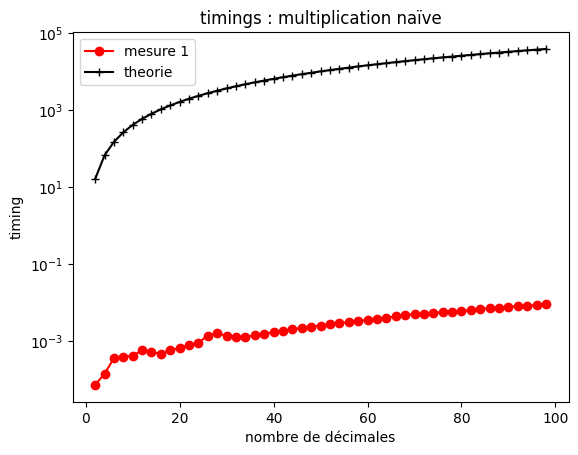

In [42]:
fig, ax = plt.subplots()
ax.plot(dizaines, timings, "ro-", label="mesure 1")
#ax.plot(dizaines, timings2, "bo-", label="mesure 2")
#ax.plot(dizaines, timings3, "g+-", label="mesure 3")
ax.plot(dizaines, comp_theorique(dizaines), "k+-", label="theorie")

ax.set_yscale("log")
ax.legend(loc='upper left')
ax.set_xlabel("nombre de décimales")
ax.set_ylabel("timing")
ax.set_title("timings : multiplication naïve")

On va tracer les log des valeurs (x, y) pour juger de la tendance quadratique :
$\ln(x^2) = 2 \times \ln(x)$.

Text(0.5, 1.0, 'timings : multiplication naïve')

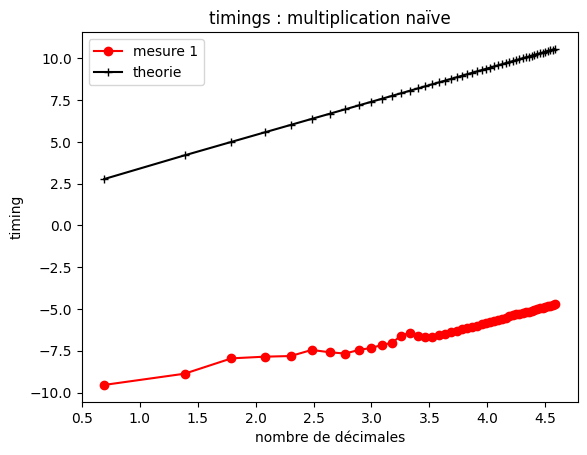

In [43]:
fig, ax = plt.subplots()
ax.plot(np.log(dizaines), np.log(timings), "ro-", label="mesure 1")
#ax.plot(np.log(dizaines), np.log(timings2), "bo-", label="mesure 2")
ax.plot(np.log(dizaines), np.log(comp_theorique(dizaines)), "k+-", label="theorie")

#ax.set_yscale("log")
ax.legend(loc='upper left')
ax.set_xlabel("nombre de décimales")
ax.set_ylabel("timing")
ax.set_title("timings : multiplication naïve")

**Analyse** 

- La tendance quadratique semble bonne. 
- Il faut normaliser par le coût en temps d'une unité de la complexité théorique.
    - Essayons quelques valeurs

In [44]:
scale = 2.3 * 10.**(-7)
scale_vect = [c*scale for c in comp_theorique(dizaines)]

Text(0.5, 1.0, 'timings : multiplication naïve')

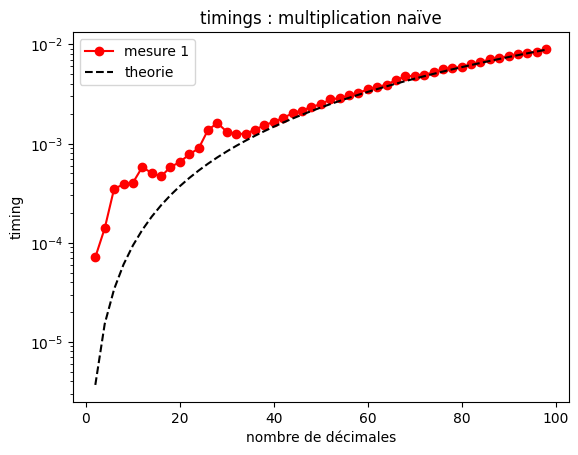

In [45]:
fig, ax = plt.subplots()

ax.plot(dizaines, timings, "ro-", label="mesure 1")
#ax.plot(dizaines, timings2, "bo-", label="mesure 2")
ax.plot(dizaines, scale_vect, "k--", label="theorie")

ax.set_yscale("log")
ax.legend(loc='upper left')
ax.set_xlabel("nombre de décimales")
ax.set_ylabel("timing")
ax.set_title("timings : multiplication naïve")

Text(0.5, 1.0, 'timings : multiplication naïve')

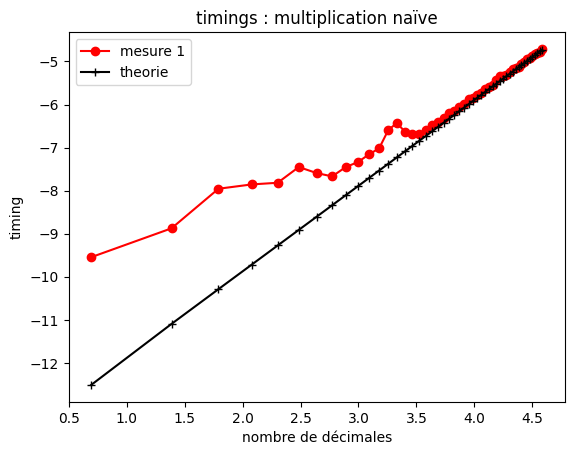

In [46]:
fig, ax = plt.subplots()
ax.plot(np.log(dizaines), np.log(timings), "ro-", label="mesure 1")
#ax.plot(np.log(dizaines), np.log(timings2), "bo-", label="mesure 2")
ax.plot(np.log(dizaines), np.log(scale_vect), "k+-", label="theorie")

ax.legend(loc='upper left')
ax.set_xlabel("nombre de décimales")
ax.set_ylabel("timing")
ax.set_title("timings : multiplication naïve")

#### Analyse plus détaillée : fitting de courbes

De façon empirique, on a exhibé a tendance quadratique de la multiplication naïve. On va vérifier ça avec [polyfit](https://numpy.org/doc/stable/reference/generated/numpy.polynomial.polynomial.polyfit.html) de `numpy.polynomial.polynomial` qui effectue une minimisation des moindres carrés.

In [47]:
from numpy.polynomial.polynomial import polyfit

res1 = polyfit(np.log(dizaines), np.log(timings), 1, full=True)
res2 = polyfit(np.log(dizaines), np.log(timings), 2, full=True)
res3 = polyfit(np.log(dizaines), np.log(timings), 3, full=True)
res4 = polyfit(np.log(dizaines), np.log(timings), 4, full=True)
print(res1)
print(res2)
print(res3)
print(res4)

(array([-10.77929946,   1.26125735]), [array([2.39802544]), 2, array([1.40432495, 0.16694742]), 1.0880185641326534e-14])
(array([-9.48860349,  0.29361638,  0.15910004]), [array([1.15087142]), 3, array([1.71167603, 0.26260134, 0.03472316]), 1.0880185641326534e-14])
(array([-10.89008474,   2.32741264,  -0.64584524,   0.0948258 ]), [array([0.6605683]), 4, array([1.96906995, 0.34495067, 0.06109168, 0.00635438]), 1.0880185641326534e-14])
(array([-11.46319871,   3.56994746,  -1.47201967,   0.31090715,
        -0.0194922 ]), [array([0.64129218]), 5, array([2.19464488e+00, 4.19501363e-01, 8.59442504e-02, 1.28473523e-02,
       1.00080130e-03]), 1.0880185641326534e-14])


Hummm difficile de déduire quelque chose ... même en observant le résidu (premier terme du second tableau résultat) qui reste très stable quand le degré des polynômes augmente ...  
Le premier tableau résultat donne les coefficients du polynôme d'approximation [a_0, a_1, a_2, ...]

## Algorithme de Karatsuba

Effectuons le produit de deux grands entiers avec l'algorithme de Karatsuba.

### Cas 1 : les opérandes sont des `int`

On commence avec des opérandes "petits", c-a-d. des `int`.


In [48]:
#from math import floor, log

In [49]:
def multK_int(u: int, v: int) -> int:
    '''multiplication Karatsuba de 2 int '''
    
    n_u = len(str(u))
    n_v = len(str(v))
    if n_u < n_v:
        u, v = v, u
        n_u, n_v = n_v, n_u
        
    if n_v < 3: # choix arbitraire
        return u * v
    
    s = n_u//2
    (w, x) = divmod(u, 10**s)
    (y, z) = divmod(v, 10**s)
    assert u == w * 10**s + x 
    assert v == y * 10**s + z 
    
    m0 = multK_int(x, z)
    m2 = multK_int(w, y)
    m1 = multK_int((w + x), (y + z)) - m0 - m2
    
    return m2 * 10**(2*s) + m1 * 10**s + m0
  

In [50]:
assert multK_int(123, 567) == 123 * 567
assert multK_int(1234, 567) == 1234 * 567
assert multK_int(12345, 567) == 12345 * 567
assert multK_int(12345, 4567) == 12345 * 4567

assert (12345678 * 56789012) == multK_int(12345678, 56789012)

### Cas 2 : les opérandes sont des grands entiers, _ie._ des `list[int]`

On suppose maintenant des opérandes représentés en liste des chiffres en base dix.  
On travaille directement avec cette représentation sans les convertir avec `intlisttoint()`.

**Rappel.** Les grands entiers sont stockés dans l'ordre de leur écriture en notation de position : 123 -> [1, 2, 3]

#### Préalable : tranches de listes et duplication

Bien regarder comment se dupliquent des listes ou des `ndarray` (types mutables) et comment se manipulent les tranches (_slicing_) de ce type d'objets.

In [51]:
t = [1,2,3]
print(t[:1], t[1:], t[:-1], t[-1:])

[1] [2, 3] [1, 2] [3]


#### `multK()` : récursion maximale et recopie

On commence avec une récursion maximale, cad. un arrêt de la récursion de Karastuba lorsque l'opérande est à 2 chiffres.

In [52]:
#from math import sqrt

In [53]:
def multK(u: list[int], v: list[int]) -> list[int]:
    '''multiplication Karatsuba de 2 grands entiers 
    solution "pas en place"
    '''

    n_u = len(u)
    n_v = len(v)
    
    if n_u < n_v:
        u, v = v, u
        n_u, n_v = n_v, n_u

    # terminaison avec récursion jusqu'à 2 chiffres (pour faciliter les derniers découpages)
    if n_u <= 2 or n_v <= 2: # 
        r = intlisttoint(u) * intlisttoint(v)
        return inttointlist(r)   

    # récursion 
    s = n_u // 2
    # noter les tranches de ndarray à la place de décalages
    (w, x) = (u[:-s].copy(), u[-s:].copy())
    (y, z) = (v[:-s].copy(), v[-s:].copy())
    
    # si le découpage créé des champs vides 
    if w == []:
        w = [0]
    if y == []:
        y = [0]
    if x == []:
        x = [0]
    if z == []:
        z = [0]
    
    # appels récursifs pour m0 et m2
    m0 = multK(x, z)
    #print("m0:", m0)
    m2 = multK(w, y)
    #print("m2:", m2)
    # add et appels récursifs pour m1
    m11 = add(w, x)
    m12 = add(y, z)
    m = multK(m11, m12)
    #print("a1:", m, neg(m0))
    a1 = add(m, neg(m0))
    #print("m1:",a1, neg(m2))
    m1 = add(a1, neg(m2))
    
    # décalages et addition finale
    m2 = decaler(m2, 2*s)
    m1 = decaler(m1, s)
    r = add(add(m2, m1), m0)
    
    # normaliser
    if r == [] or r == [0]:
        return [0]
    elif signe(r) == 0:
        i = 0
    else:
        i = 1
    while len(r[i:]) > 0 and r[i] == 0:
        r.pop(i)
        
    return r
  

In [54]:
assert multK([1], [5,6,7]) == inttointlist(567)
assert multK([5,6,7], [1]) == inttointlist(567)
assert multK([1,2], [1,1]) == inttointlist(12 * 11)
assert multK([1,2,3], [1,1]) == inttointlist(123 * 11)
assert multK([1,2,3], [4,5,6]) == inttointlist(123 * 456)
assert multK([1,2,3,4,5,6,7,8], [4,5,6]) == inttointlist(12345678 * 456)

#### `multK0()`: une seconde récursion maximale en place

On fait confiance à la gestion des références par l'environnement Python.

In [55]:
def multK0(u: list[int], v: list[int]) -> list[int]:
    '''multiplication Karatsuba de 2 grands entiers 
    solution "en place"
    '''
    n_u = len(u)
    n_v = len(v)

    # terminaison avec récursion maximale
    if n_u == 1:
        r = int(u[0]) * intlisttoint(v) 
        return inttointlist(r)
    elif n_v == 1: # 1 chiffre
        r = int(v[0]) * intlisttoint(u)
        return inttointlist(r)   

    # récursion 
    s = max(n_u, n_v)//2
    # noter les tranches de ndarray à la place de décalages
    (w, x) = (u[-n_u:-s], u[-s:])
    (y, z) = (v[-n_v:-s], v[-s:])
    if w == []:
        w = [0]
    if y == []:
        y = [0]
        
    #print("u:", u, w, x)
    #print("v:", v, y, z)
    m2 = multK(w, y)
    #print(m2)
    
    m11 = multK(w, z)
    m12 = multK(x, y)
    m1 = add(m11, m12)
    #print(m11, m12, m1)
    
    m0 = multK(x, z)
    #print(m0)    
    
    #print(s, m2, m1, m0)
    
    m2 = decaler(m2, 2*s)
    m1 = decaler(m1, s)
    #print("m2, m1, m0", m2, m1, m0) 
    r = add(add(m2, m1), m0)
    return r
  

In [56]:
assert multK0([1], [5,6,7]) == inttointlist(567)
assert multK0([5,6,7], [1]) == inttointlist(567)
assert multK0([1,2], [1,1]) == inttointlist(12 * 11)
assert multK0([1,2,3], [1,1]) == inttointlist(123 * 11)
assert multK0([1,2,3], [4,5,6]) == inttointlist(123 * 456)
assert multK0([1,2,3,4,5,6,7,8], [4,5,6]) == inttointlist(12345678 * 456)

## Timings et tracés

### Plusieurs dizaines de décimales

On part de _Mesure 1_ en excluant cette fois la mesure de la transformation dans la représentation des grands entiers (comme _Mesure 3_ en fait).

In [73]:
nbtests = 5
dizaines = [n for n in range(11, 101, 10)]

In [74]:
timingsMult = []
timingsKarat = []
#timingsKarat0 = []

for nbchiffres in dizaines: 
    a = 10 ** nbchiffres
    b = (10 ** (nbchiffres + 1)) - 1
    tempstotM = 0.
    tempstotK = 0.
    #tempstotK0 = 0.
    
    for i in range(nbtests):
        x = randint(a, b)
        y = randint(a, b)

        mon_x = inttointlist(x)
        mon_y = inttointlist(y)
        
        t0 = time.perf_counter()
        mon_xy = mult(mon_x, mon_y)
        t = time.perf_counter()       
        tempstotM += (t - t0)

        t0 = time.perf_counter()
        mon_xy = multK(mon_x, mon_y)
        t = time.perf_counter()       
        tempstotK += (t - t0)
        '''
        t0 = time.perf_counter()
        mon_xy = multK0(mon_x, mon_y)
        t = time.perf_counter()       
        tempstotK0 += (t - t0)
        '''

        
    timingsMult.append(tempstotM/nbtests)
    timingsKarat.append(tempstotK/nbtests)
    #timingsKarat0.append(tempstotK0/nbtests)
 
#for i in range(len(dizaines)):
#    print("n=", dizaines[i], "t=", "{:5.3e}".format(timings[i]))

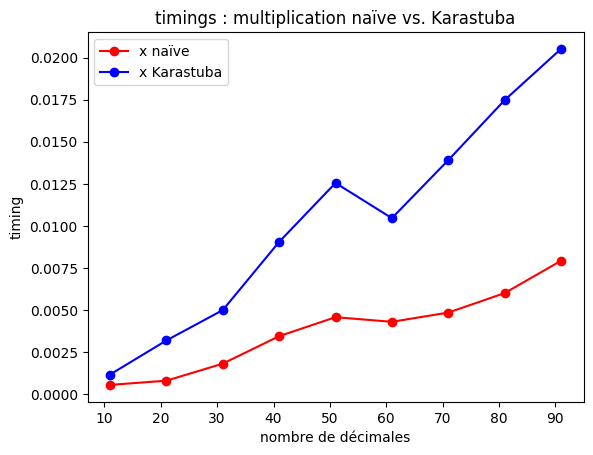

In [75]:
# des courbes de références
x1 = [x for x in dizaines]
x2 = [x*x for x in dizaines]

fig, ax = plt.subplots()
ax.plot(dizaines, timingsMult, "ro-", label="x naïve")
ax.plot(dizaines, timingsKarat, "bo-", label="x Karastuba")
#ax.plot(dizaines, timingsKarat0, "go-", label="x Karastuba en place")
#ax.plot(dizaines, comp_theorique(dizaines), "k+-", label="theorie")
#ax.plot(dizaines, x1, "k+-", label="x*x")


ax.legend(loc='upper left')
ax.set_xlabel("nombre de décimales")
ax.set_ylabel("timing")
ax.set_title("timings : multiplication naïve vs. Karastuba")

fig.savefig("./multNvsKdizaines.png")

### Plusieurs centaines de décimales

On va tracer ces timings avec une échelle logarithmique sur l'axe de y.

In [60]:
nbtests = 2
centaines = [n for n in range(101, 1001, 100)]
timingsMult = []
timingsKarat = []
#timingsKarat0 = []

In [61]:
for nbchiffres in centaines: 
    a = 10 ** nbchiffres
    b = (10 ** (nbchiffres + 1)) - 1
    tempstotM = 0.
    tempstotK = 0.
    tempstotK0 = 0.
    
    for i in range(nbtests):
        x = randint(a, b)
        y = randint(a, b)

        mon_x = inttointlist(x)
        mon_y = inttointlist(y)
        
        t0 = time.perf_counter()
        mon_xy = mult(mon_x, mon_y)
        t = time.perf_counter()       
        tempstotM += (t - t0)

        t0 = time.perf_counter()
        mon_xy = multK(mon_x, mon_y)
        t = time.perf_counter()       
        tempstotK += (t - t0)

        '''
        t0 = time.perf_counter()
        mon_xy = multK0(mon_x, mon_y)
        t = time.perf_counter()       
        tempstotK0 += (t - t0)
        '''

    timingsMult.append(tempstotM/nbtests)
    timingsKarat.append(tempstotK/nbtests)
    #timingsKarat0.append(tempstotK0/nbtests)
 
#for i in range(len(centaines)):
#    print("n=", centaines[i], "t=", "{:5.3e}".format(timings[i]))

Text(0.5, 1.0, 'timings : multiplication naïve vs. Karastuba')

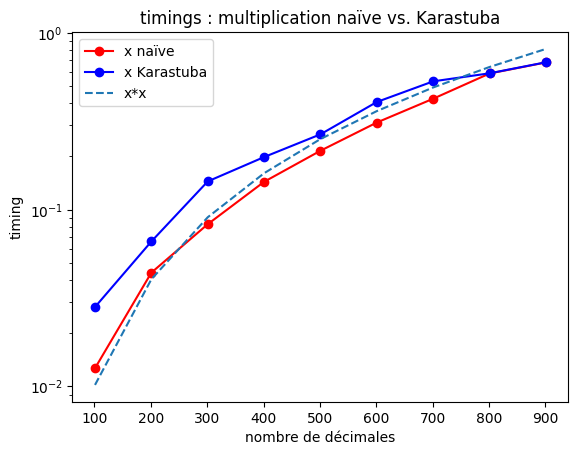

In [62]:
# des courbes de références
scalex = 10**(-6)
x2 = [x*x*scalex for x in centaines]

fig, ax = plt.subplots()
ax.plot(centaines, timingsMult, "ro-", label="x naïve")
ax.plot(centaines, timingsKarat, "bo-", label="x Karastuba")
#ax.plot(centaines, timingsKarat0, "go-", label="x Karastuba en place")
ax.plot(centaines, x2, "--", label="x*x")
#ax.plot(centaines, comp_theorique(centaines), "k+-", label="theorie")

ax.set_yscale("log")
ax.legend(loc='upper left')
ax.set_xlabel("nombre de décimales")
ax.set_ylabel("timing")
ax.set_title("timings : multiplication naïve vs. Karastuba")

### Des centaines et milliers de décimales puissances de 2

Ces résultats décevants de Karatsuba interrogent.
On peut se demander si une récursion optimale change la tendance.
On se restreint donc aux centaines qui sont des puissances de 2.

In [70]:
nbtests = 2
puissances2 = [_ for _ in range(8, 13)]
p2 = [2**p for p in puissances2]
print(p2)

[256, 512, 1024, 2048, 4096]


In [63]:
                                         
timingsMult = []
timingsKarat = []
#timingsKarat0 = []

[256, 512, 1024, 2048, 4096]


In [64]:
for nbchiffres in p2: 
    a = 10 ** nbchiffres
    b = (10 ** (nbchiffres + 1)) - 1
    tempstotM = 0.
    tempstotK = 0.
    #tempstotK0 = 0.
    
    for i in range(nbtests):
        x = randint(a, b)
        y = randint(a, b)

        mon_x = inttointlist(x)
        mon_y = inttointlist(y)
        
        t0 = time.perf_counter()
        mon_xy = mult(mon_x, mon_y)
        t = time.perf_counter()       
        tempstotM += (t - t0)

        t0 = time.perf_counter()
        mon_xy = multK(mon_x, mon_y)
        t = time.perf_counter()       
        tempstotK += (t - t0)

        '''
        t0 = time.perf_counter()
        mon_xy = multK0(mon_x, mon_y)
        t = time.perf_counter()       
        tempstotK0 += (t - t0)
        '''

    timingsMult.append(tempstotM/nbtests)
    timingsKarat.append(tempstotK/nbtests)
    #timingsKarat0.append(tempstotK0/nbtests)
 
#for i in range(len(centaines)):
#    print("n=", centaines[i], "t=", "{:5.3e}".format(timings[i]))

Text(0.5, 1.0, 'timings pour des dimensions en 2**i : multiplication naïve vs. Karastuba')

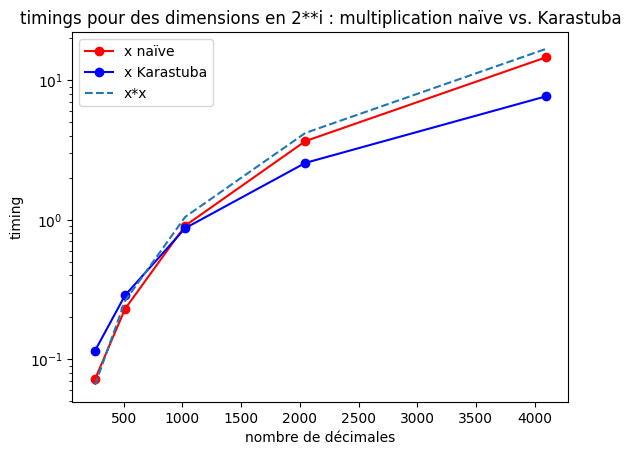

In [65]:
# des courbes de références
scalex = 10**(-6)
x2 = [x*x*scalex for x in p2]

fig, ax = plt.subplots()
ax.plot(p2, timingsMult, "ro-", label="x naïve")
ax.plot(p2, timingsKarat, "bo-", label="x Karastuba")
#ax.plot(centaines, timingsKarat0, "go-", label="x Karastuba en place")
ax.plot(p2, x2, "--", label="x*x")
#ax.plot(centaines, comp_theorique(centaines), "k+-", label="theorie")

ax.set_yscale("log")
ax.legend(loc='upper left')
ax.set_xlabel("nombre de décimales")
ax.set_ylabel("timing")
ax.set_title("timings pour des dimensions en 2**i : multiplication naïve vs. Karastuba")

La cellule suivante pour éviter de tout recalculer en augmentant le range du nombre de décimales.
- on limite la mesure au nouveau range
- on ajoute les mesures aux mesures précédentes
- on save le range précédent qu'on mettra à jour à l'affichage

In [71]:
nbtests = 2
puissances2 = [_ for _ in range(13, 14)]
save_p2 = p2
p2 = [2**p for p in puissances2]
print(p2)
                                         
#timingsMult = []
#timingsKarat = []
#timingsKarat0 = []

[8192]


In [67]:
for nbchiffres in p2: 
    a = 10 ** nbchiffres
    b = (10 ** (nbchiffres + 1)) - 1
    tempstotM = 0.
    tempstotK = 0.
    #tempstotK0 = 0.
    
    for i in range(nbtests):
        x = randint(a, b)
        y = randint(a, b)

        mon_x = inttointlist(x)
        mon_y = inttointlist(y)
        
        t0 = time.perf_counter()
        mon_xy = mult(mon_x, mon_y)
        t = time.perf_counter()       
        tempstotM += (t - t0)

        t0 = time.perf_counter()
        mon_xy = multK(mon_x, mon_y)
        t = time.perf_counter()       
        tempstotK += (t - t0)

        '''
        t0 = time.perf_counter()
        mon_xy = multK0(mon_x, mon_y)
        t = time.perf_counter()       
        tempstotK0 += (t - t0)
        '''

    timingsMult.append(tempstotM/nbtests)
    timingsKarat.append(tempstotK/nbtests)
    #timingsKarat0.append(tempstotK0/nbtests)
 
#for i in range(len(centaines)):
#    print("n=", centaines[i], "t=", "{:5.3e}".format(timings[i]))

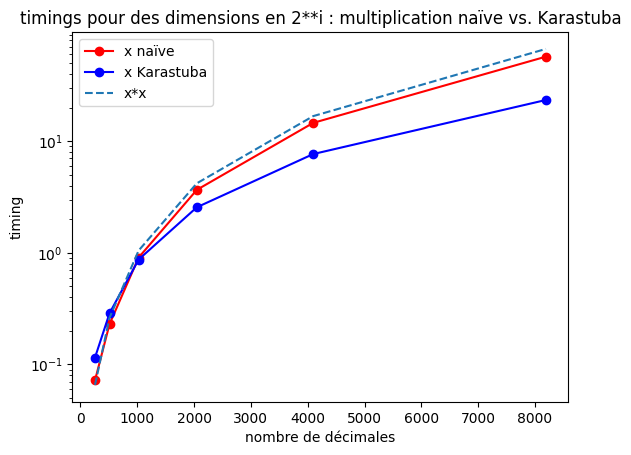

In [72]:
# si besoin
p2 = save_p2 + p2
# des courbes de références
scalex = 10**(-6)
x2 = [x*x*scalex for x in p2]

fig, ax = plt.subplots()
ax.plot(p2, timingsMult, "ro-", label="x naïve")
ax.plot(p2, timingsKarat, "bo-", label="x Karastuba")
#ax.plot(centaines, timingsKarat0, "go-", label="x Karastuba en place")
ax.plot(p2, x2, "--", label="x*x")
#ax.plot(centaines, comp_theorique(centaines), "k+-", label="theorie")

ax.set_yscale("log")
ax.legend(loc='upper left')
ax.set_xlabel("nombre de décimales")
ax.set_ylabel("timing")
ax.set_title("timings pour des dimensions en 2**i : multiplication naïve vs. Karastuba")

fig.savefig("./multNvsKpuiss2.png")

## Conclusion intermédiaire

La performance _mesurée_ de la multiplication de Karastuba est décevante pour un nombre de décimales inférieur au millier -- ce qui est beaucoup. 
La multiplication naïve reste plus performante jusqu'à 500 décimales environ.
Cette valeur déterminera donc le seuil d'une multiplication efficace de grands entiers **avec la représentation actuellement utilisée**.


Comment expliquer cette inefficacité pratique de la solution de Karastuba pour un nombre de décimales "réduit" ? 

- l'impact des "constantes cachées" qui viennent des additions et des nombreuses fonctions intermédiaires nécessaires pour l'implanter pour la représentation, choisie
- le coût des appels récursifs 
- le coût de la  duplications des opérandes 
- la représentation choisie pour nos grands entiers : des tableaux de chiffres en base 10


En revanche, l'impact de la copie ou de la solution en place n'est pas significative pour un nombre important de décimales, ici de l'ordre de 1000.

## Avec GMP

[`gmpy2`](https://gmpy2.readthedocs.io/en/latest/index.html) permet de travailler avec [GMP](http://gmp.org) et de manipuler des entiers arbitrairement longs de type `mpz`.

### `gmpy2.mul()`

On peut suppposer qu'un Karactsuba (bien optimsé) est derrière `gmpy2.mul()`.
Regardons-ça ...

In [49]:
#from gmpy2 import mpz, mul

In [76]:
x = mpz("999999999999")
print(x, type(x))
y = mpz(str(randint(1,9)) * 5)
print(y)

999999999999 <class 'mpz'>
66666


### Timings

In [77]:
nmin = 3000
nmax = 15000
pas = 100
nbtests = 10
nbdigits = []
timingsMPZ = []
for n in range(nmin, nmax, pas):
    ttot = 0
    for i in range(nbtests):
        # a et b ont n chiffres aléatoires
        a = str(randint(1,9)) * n
        b = str(randint(1,9)) * n
        
        # voilà des mpz
        aa = mpz(a)
        bb = mpz(b)

        # on les multiplie
        t0 = time.perf_counter()
        cc = mul(aa, bb)
        t = time.perf_counter()
        
        ttot += (t - t0)
    
    nbdigits.append(mpz.num_digits(aa))
    timingsMPZ.append(ttot/nbtests)
        
#print(nbdigits, timingsMPZ)

### Tracés

Text(0.5, 1.0, 'timings : multiplication Karastuba')

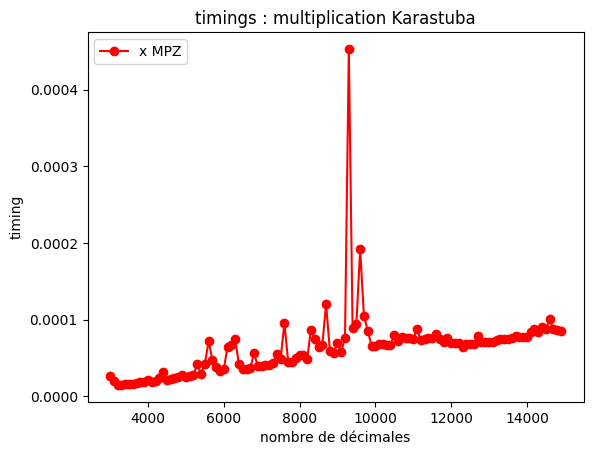

In [78]:
fig, ax = plt.subplots()
ax.plot(nbdigits, timingsMPZ, "ro-", label="x MPZ")
#ax.plot(nbdigits, comp_theorique(nbdigits), "k+-", label="theorie")
#ax.plot(nbdigits, x1, "k+-", label="x*x")

ax.legend(loc='upper left')
ax.set_xlabel("nombre de décimales")
ax.set_ylabel("timing")
ax.set_title("timings : multiplication Karastuba")

In [53]:
help(np.log)

Help on ufunc:

log = <ufunc 'log'>
    log(x, /, out=None, *, where=True, casting='same_kind', order='K', dtype=None, subok=True[, signature, extobj])
    
    Natural logarithm, element-wise.
    
    The natural logarithm `log` is the inverse of the exponential function,
    so that `log(exp(x)) = x`. The natural logarithm is logarithm in base
    `e`.
    
    Parameters
    ----------
    x : array_like
        Input value.
    out : ndarray, None, or tuple of ndarray and None, optional
        A location into which the result is stored. If provided, it must have
        a shape that the inputs broadcast to. If not provided or None,
        a freshly-allocated array is returned. A tuple (possible only as a
        keyword argument) must have length equal to the number of outputs.
    where : array_like, optional
        This condition is broadcast over the input. At locations where the
        condition is True, the `out` array will be set to the ufunc result.
        Elsewhere, t

### Complexité théorique de Karastuba

In [79]:
def comp_theo_Karatsuba(n):
    return np.power(n, np.log2(3))

In [80]:
print(np.log2(3))
t = [2**i for i in range(5)]
nt = np.array(t)
# (2^i)^log_2(3) = 3^i
print(t, comp_theo_Karatsuba(t))
print(nt, comp_theo_Karatsuba(nt))
# effet scaling sur np.array
print(nt, comp_theo_Karatsuba(nt)*2)

1.584962500721156
[1, 2, 4, 8, 16] [ 1.  3.  9. 27. 81.]
[ 1  2  4  8 16] [ 1.  3.  9. 27. 81.]
[ 1  2  4  8 16] [  2.   6.  18.  54. 162.]


### Et en échelle log avec un peu de _scaling_.

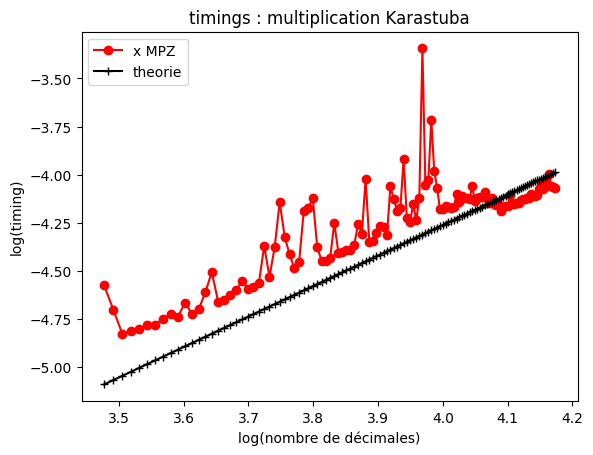

In [82]:
fig, ax = plt.subplots()
ax.plot(np.log10(nbdigits), np.log10(timingsMPZ), "ro-", label="x MPZ")
# on trouve une valeur acceptable par essais successifs
scaleK = 2.5*10**(-11)
ax.plot(np.log10(nbdigits), np.log10(comp_theo_Karatsuba(nbdigits)*scaleK), "k+-", label="theorie")
#ax.plot(nbdigits, x1, "k+-", label="x*x")


ax.legend(loc='upper left')
ax.set_xlabel("log(nombre de décimales)")
ax.set_ylabel("log(timing)")
ax.set_title("timings : multiplication Karastuba")

fig.savefig("./gmp_Kvstheor.png")

### Observations

- Quelle efficacité **impressionante** de cette implémentation : des résultats immédiats pour des nombre à plusieurs milliers de décimales : de 1000 à 15000 pour le timings !!
- `mul` de `gmpy2` suit la tendance asymptotique théorique.
    - il semble que l'efficacité s'améliore (_vs._ la borne théorique) lorsque le nombre de décimale augmente 
    - on remarque un changement de comportement qualitatif pour la plage de décimales [10000, 12000] -- cette descente se reproduit -- pour quelles raisons ?
- On retrouve donc un comportement plus conforme à la théorie qu'avec notre représentation et nos précédentes implantations de ces algorithmes. 

## Reprenons notre solution avec espoir 

On va donc reprendre notre représentation et les traitements associés pour tenter d'améliorer l'efficacité de notre solution.



### Une autre représentation de grands entiers positifs

On va inverser la représentation précédente : un entier positif est maintenant représenté par la liste de ces chiffres (en base 10) stockés dans une liste par ordre **décroissant de son exposant** en notation de position.

Maintenant le chiffre de plus faible exposant est **en début de la liste** qui stocke ses chiffres.

Ainsi $123 = 1 + 2 \times 10 + 3 \times 10^2$  sera représenté par la liste `[3, 2, 1]`. 

On espère que les manipulations de liste qui impactent les chiffres les plus à droite seront moins pénalisantes que si elles étaient effectuées en début de liste.

On reprend nos traitements précédents en les limitant à ceux nécessaires pour la multiplication de Karatsuba. Ne pas hésiter à recopier les cellules précédentes et effectuer les modifications des différentes pour cette nouvelle représentation.

**Notation :** les fonctions pour cette nouvelle représentation seront suffixées par `2`, _eg._ `intlist2`, ....

### Identification des besoins

Notre traitement de Karatsuba utilise les fonctions suivantes :

- `inttointlist`
- `intlisttoint() `
- `add()`
- `decaler()`

### `inttointlist2()`

In [56]:
def inttointlist2(n : int) -> list[int]:
    if n == 0:
        return [0]
    res = []
    while n > 0:
        res.append(n % 10)
        n = n // 10
    return res

In [57]:
assert inttointlist2(0) == [0]
assert inttointlist2(4) == [4]
assert inttointlist2(84) == [4, 8]
assert inttointlist2(123) == [3, 2, 1]

### `intlisttoint2()`

In [58]:
def intlisttoint2(l : list[int]) -> int:
    res = 0
    for i in range(len(l)):
        res = res + l[i] * 10**i
    return res

In [59]:
assert intlisttoint2([0]) == 0
assert intlisttoint2([8, 9]) == 98
assert intlisttoint2([1, 2, 3]) == 321

### `add2()`

In [60]:
def add2(u: list[int], v: list[int]) -> list[int]:
    '''cette solution fait 2 parcours de res 
    pour réduire le nombre de test de chaque parcours'''
    if len(u) < len(v):
        u, v = v, u
    assert len(u) >= len(v)
    
    # res = u pour commencer
    res = [u[i] for i in range(len(u))]
    
    # add v chiffre à chiffre dans u
    for i in range(len(v)):
        res[i] = res[i] + v[i]               

    # propag retenues de gauche à droite       
    for i in range(len(res)): 
        if res[i] > 9: # il y une retenue
            res[i] = res[i] % 10
            if i + 1 < len(res) : 
                res[i+1] += 1
            else:
                res.append(1) # ajout chiffre de poids fort 
                
    return res      

In [61]:
assert add2([2], [1]) == [3]
assert add2([1], [2]) == [3]
assert add2([0, 1], [2, 0]) == [2, 1]
assert add2([8], [3]) == [1, 1]
assert add2([8, 9], [1]) == [9, 9]
assert add2([9, 9], [2]) == [1, 0, 1]

### `decaler2()`

In [62]:
def decaler2(u: list[int], p: int) -> list[int]:
    '''décale le grand entier u de p positions vers la gauche
    cad. ajoute p 0 au début de u'''
    return [0 for i in range(p)] + u

In [63]:
assert decaler2([1], 2) == [0, 0, 1]
assert decaler2([1], 3) == [0, 0, 0, 1]
assert decaler2([9, 9], 0) == [9, 9]
assert decaler2([9, 9], 1) == [0, 9, 9]

### `multK2` : algorithme de Karatsuba

In [64]:
def multK2(u: list[int], v: list[int]) -> list[int]:
    '''multiplication Karatsuba de 2 grands entiers 
    solution "en place"
    '''
    n_u = len(u)
    n_v = len(v)

    # terminaison avec récursion maximale
    if n_u == 1:
        r = int(u[0]) * intlisttoint2(v) 
        return inttointlist2(r)
    elif n_v == 1: # 1 chiffre
        r = int(v[0]) * intlisttoint2(u)
        return inttointlist2(r)   

    # récursion 
    s = max(n_u, n_v)//2
    # noter les tranches de ndarray à la place de décalages
    # sans copie dans cette version
    (w, x) = (u[s:], u[:s])
    (y, z) = (v[s:], v[:s])
    if w == []:
        w = [0]
    if y == []:
        y = [0]
        
    #print("u:", u, "->", w, x)
    #print("v:", v, "->", y, z)
    m2 = multK2(w, y)
    m0 = multK2(x, z)
    #print(m2)
    #print(m0)    
   
    m11 = multK2(w, z)
    m12 = multK2(x, y)
    m1 = add2(m11, m12)
    #print(m11, m12, m1)
    
    #print(s, m2, m1, m0)
    
    m2 = decaler2(m2, 2*s)
    m1 = decaler2(m1, s)
    #print("m2, m1, m0", m2, m1, m0) 
    r = add2(add2(m2, m1), m0)
    return r
  

In [65]:
assert multK2([1], [5,6,7]) == inttointlist2(765)
assert multK2([5,6,7], [1]) == inttointlist2(765)
assert multK2([2,2], [1,1]) == inttointlist2(22 * 11)
assert multK2([6,6,6], [1,1]) == inttointlist2(666 * 11)
assert multK2([1,2,3], [4,5,6]) == inttointlist2(321 * 654)
assert multK2([1,2,3,4,5,6,7,8], [4,5,6]) == inttointlist2(87654321 * 654)

### Timings 

On reprend _Mesure 1_ comme _Mesure 3_ en fait.

On effectue 5 tests pour chaque choix de nombre de décimales.
Il est cette fois beaucoup plus facile de tester des nombres de décimales plus important sur nos machines (en comparaison avec la première solution).

#### Pour plusieurs centaines de décimales  

Par exemple, la configuration suivante prend moins d'une minute sur ma machine et teste toutes les centaines de décimales.

```python
nbtests = 5
centaines = [n for n in range(100, 1000, 100)]
```

In [88]:
nbtests = 5
centaines = [n for n in range(100, 1000, 100)]

In [89]:
#timingsMult = []
timingsKarat = []
timingsKarat2 = []

for nbchiffres in centaines: 
    a = 10 ** nbchiffres
    b = (10 ** (nbchiffres + 1)) - 1

    tempstotK = 0.
    tempstotK2 = 0.
    
    for i in range(nbtests):
        x = randint(a, b)
        y = randint(a, b)

        mon_x = inttointlist(x)
        mon_y = inttointlist(y)
        
        t0 = time.perf_counter()
        mon_xy = multK(mon_x, mon_y)
        t = time.perf_counter()       
        tempstotK += (t - t0)

        mon_x = inttointlist2(x)
        mon_y = inttointlist2(y)

        t0 = time.perf_counter()
        mon_xy = multK2(mon_x, mon_y)
        t = time.perf_counter()       
        tempstotK2 += (t - t0)
        
    timingsKarat.append(tempstotK/nbtests)
    timingsKarat2.append(tempstotK2/nbtests)
 

Text(0.5, 1.0, 'timings : multiplication Karastuba, version 2')

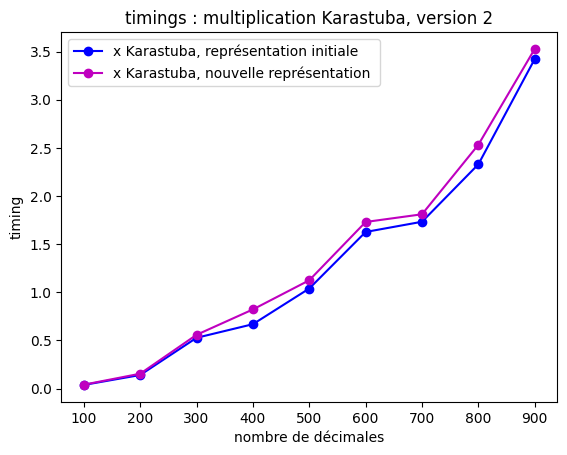

In [93]:
# des courbes de références
x1 = [x for x in centaines]
x2 = [x*x for x in centaines]

fig, ax = plt.subplots()
ax.plot(centaines, timingsKarat, "bo-", label="x Karastuba, représentation initiale")
ax.plot(centaines, timingsKarat2, "mo-", label="x Karastuba, nouvelle représentation ")
#ax.plot(centaines, comp_theorique(centaines), "k+-", label="theorie")
#ax.plot(centaines, x1, "k+-", label="x*x")


ax.legend(loc='upper left')
ax.set_xlabel("nombre de décimales")
ax.set_ylabel("timing")
ax.set_title("timings : multiplication Karastuba, version 2")

Et en échelle log avec un peu de _scaling_.

Text(0.5, 1.0, 'timings : multiplication Karastuba version 2')

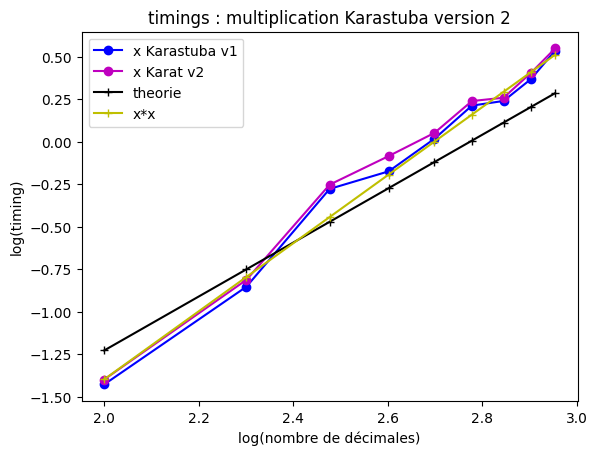

In [106]:
fig, ax = plt.subplots()
ax.plot(np.log10(centaines), np.log10(timingsKarat), "bo-", label="x Karastuba v1")
ax.plot(np.log10(centaines), np.log10(timingsKarat2), "mo-", label="x Karat v2")
# on trouve une valeur acceptable par essais successifs
scaleK = 4*10**(-5)
ax.plot(np.log10(centaines), np.log10(comp_theo_Karatsuba(centaines)*scaleK), "k+-", label="theorie")
ax.plot(np.log10(centaines), np.log10(np.array(x2)*scaleK*0.1), "y+-", label="x*x")


ax.legend(loc='upper left')
ax.set_xlabel("log(nombre de décimales)")
ax.set_ylabel("log(timing)")
ax.set_title("timings : multiplication Karastuba version 2")

#### Un dernier tracé pour résumer cette partie

On reprend la dernière exécution pour le produit naïf et on compare le tout. 

In [83]:
nbtests = 5
centaines = [n for n in range(100, 1000, 100)]

Text(0.5, 1.0, 'timings : multiplication Karastuba, version 2')

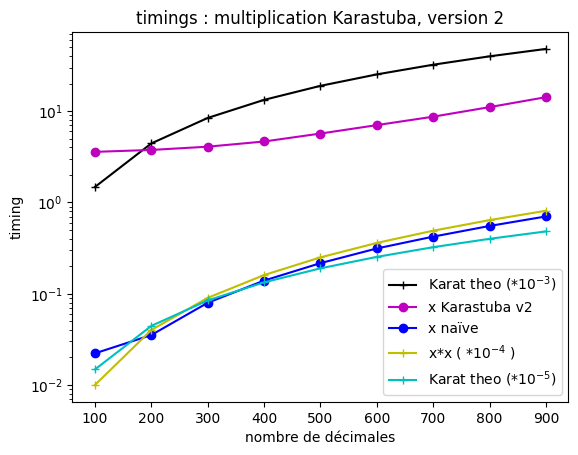

In [158]:
# des courbes de références
x1 = np.array([x for x in centaines])
x2 = np.array([x*x for x in centaines])
#xK = [np.power(x, np.log2(3)) for x in centaines]

fig, ax = plt.subplots()

scale2 = 10**(-3)
ax.plot(centaines, comp_theo_Karatsuba(centaines)*scale2, "k+-", label="Karat theo ($*10^{-3}$)") 
ax.plot(centaines, timingsKarat2, "mo-", label="x Karastuba v2 ")

scale1 = 10**(-5)
ax.plot(centaines, timingsMult, "bo-", label="x naïve")
ax.plot(centaines, x2*scale1*10**(-1), "y+-", label="x*x ( $*10^{-4}$ )")
ax.plot(centaines, comp_theo_Karatsuba(centaines)*scale1, "c+-", label="Karat theo ($*10^{-5}$)")
#ax.plot(centaines, xK, "c+-", label="x")


ax.set_yscale('log')
ax.legend(loc='lower right')
ax.set_xlabel("nombre de décimales")
ax.set_ylabel("timing")
ax.set_title("timings : multiplication Karastuba, version 2")

## Conclusion

- La solution v2 de Karastuba est toujours moins rapide que la solution naïve, et la tendance asymptotique accentue ce comportement. Pourquoi ? 

- Karatsuba v2 : on ne retrouve **toujours pas** la tendance de la complexité théorique pour des nombres avec quelques centaines de décimales
    - on a encore la tendance quadratique de la solution de la représentation précédente 
    - et ce malgré l'importance du choix de la structure de données sur les performances de l'algorithme
        - ici meilleur a priori car utilisation des listes python en cohérence avec leur logique d'implantation FILO avec indexation croissante.
    



In [64]:
def multK3(u: list[int], v: list[int]) -> list[int]:
    '''multiplication Karatsuba de 2 grands entiers 
    solution "en place"
    '''
    # u est l'opérande le plus long
    if len(u) < len(v):
        u, v = v, u

    # terminaison avec récursion maximale
    if len(v) == 1:
        r = int(v[0]) * intlisttoint2(u)
        return inttointlist2(r)   

    # récursion 
    s = len(u)//2
    # noter les tranches de ndarray à la place de décalages
    # sans copie dans cette version
    (w, x) = (u[s:], u[:s])
    (y, z) = (v[s:], v[:s])
    if y == []:
        y = [0]
        
    #print("u:", u, "->", w, x)
    #print("v:", v, "->", y, z)
    m2 = multK3(w, y)
    m0 = multK3(x, z)
    #print(m2)
    #print(m0)    
   
    m11 = multK2(w, z)
    m12 = multK2(x, y)
    m1 = add2(m11, m12)
    #print(m11, m12, m1)
    
    #print(s, m2, m1, m0)
    
    m2 = decaler2(m2, 2*s)
    m1 = decaler2(m1, s)
    #print("m2, m1, m0", m2, m1, m0) 
    r = add2(add2(m2, m1), m0)
    return r
  

In [88]:
nbtests = 5
centaines = [n for n in range(100, 400, 100)]

In [89]:
#timingsMult = []
timingsKarat = []
timingsKarat2 = []

for nbchiffres in centaines: 
    a = 10 ** nbchiffres
    b = (10 ** (nbchiffres + 1)) - 1

    tempstotK = 0.
    tempstotK2 = 0.
    
    for i in range(nbtests):
        x = randint(a, b)
        y = randint(a, b)

        mon_x = inttointlist(x)
        mon_y = inttointlist(y)
        
        t0 = time.perf_counter()
        mon_xy = multK(mon_x, mon_y)
        t = time.perf_counter()       
        tempstotK += (t - t0)

        mon_x = inttointlist2(x)
        mon_y = inttointlist2(y)

        t0 = time.perf_counter()
        mon_xy = multK2(mon_x, mon_y)
        t = time.perf_counter()       
        tempstotK2 += (t - t0)
        
    timingsKarat.append(tempstotK/nbtests)
    timingsKarat2.append(tempstotK2/nbtests)
 

Text(0.5, 1.0, 'timings : multiplication Karastuba, version 2')

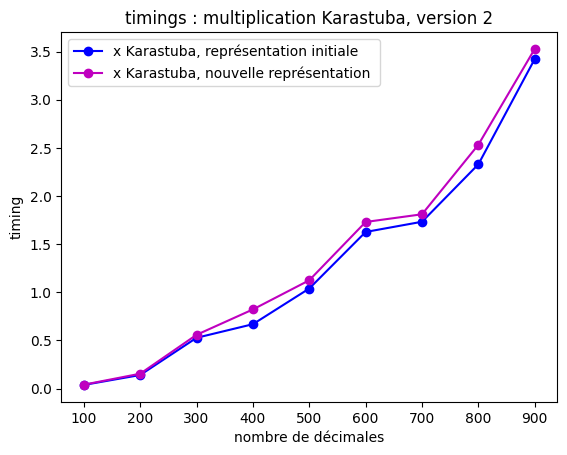

In [93]:
# des courbes de références
x1 = [x for x in centaines]
x2 = [x*x for x in centaines]

fig, ax = plt.subplots()
ax.plot(centaines, timingsKarat, "bo-", label="x Karastuba, représentation initiale")
ax.plot(centaines, timingsKarat2, "mo-", label="x Karastuba, nouvelle représentation ")
#ax.plot(centaines, comp_theorique(centaines), "k+-", label="theorie")
#ax.plot(centaines, x1, "k+-", label="x*x")


ax.legend(loc='upper left')
ax.set_xlabel("nombre de décimales")
ax.set_ylabel("timing")
ax.set_title("timings : multiplication Karastuba, version 2")